#**Factors Contributing to SF Taxi Fare Pricing**

In [1]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


San Fransisco taxi trip data 2023-2025. Data & data dictionary available at https://data.sfgov.org/Transportation/Taxi-Trips/m8hk-2ipk/about_data

In [2]:
taxi_data = pd.read_csv('/content/Taxi_Trip_Data.csv', engine='python')

###**Data Cleaning and Formating**
Data that indicates error or far exceeds the normal bounds of a taxi trip are excluded.

For instance trips with:
*   Distance of zero
*   Fares over $1000
*   Trips exceeding 2 hours

In [3]:
format_string = "%Y/%m/%d %I:%M:%S %p"
taxi_data['start_time_local'] = pd.to_datetime(taxi_data['start_time_local'], format=format_string)
taxi_data['end_time_local'] = pd.to_datetime(taxi_data['end_time_local'], format=format_string)

taxi_data['total_fare_amount'] = pd.to_numeric(taxi_data['total_fare_amount'], errors='coerce')
taxi_data['trip_distance_meters'] = pd.to_numeric(taxi_data['trip_distance_meters'], errors='coerce')


taxi_data['trip_duration_ms'] = (
    pd.to_datetime(taxi_data['end_time_local']) - pd.to_datetime(taxi_data['start_time_local'])
).dt.total_seconds() * 1000

taxi_data['trip_duration_ms'].dropna()
taxi_data['trip_duration_ms'] = pd.to_numeric(taxi_data['trip_duration_ms'], errors='coerce')
taxi_data = taxi_data[taxi_data['trip_duration_ms'] > 0]



fare_dist_cleaned_df = taxi_data[['total_fare_amount', 'trip_distance_meters']].dropna()

taxi_data_complete = taxi_data
taxi_data = taxi_data[
    (taxi_data['total_fare_amount'] > 0) &
    (taxi_data['total_fare_amount'] < 1000) &
    (taxi_data['trip_distance_meters'] > 0) &
    (taxi_data['trip_duration_ms'] > 0) &
    (taxi_data['trip_duration_ms'] < 7200000)
]


###**Overview of Main Analysis**
The following section examines the relationship between total fare price and trip characteristics, including distance, duration, day of week, and time of day. Scatterplots and correlation measurements are used to gauge the strength and direction of these relationships. To ensure the reflection of typical taxi trips, the analysis revolves around a cleaned dataset, which excludes invalid records, such as negative trip durations. For added context, summary statistics of the complete dataset are also referenced to illustrate how atypical trips, like those exceeding two hours, influence relationships and can obscure patterns in standard rides.

**Distance and Total Fare**

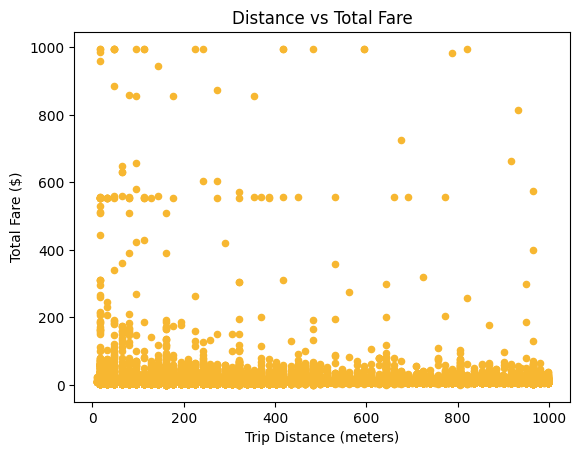

Correlation Coefficient: 0.027750774140196693


In [4]:
taxi_data.plot.scatter(x='trip_distance_meters',y='total_fare_amount', color = '#F7B731')
plt.title('Distance vs Total Fare')
plt.xlabel('Trip Distance (meters)')
plt.ylabel('Total Fare ($)')
plt.show()

fare_distance_corr_coefficient, p_value_1 = pearsonr(fare_dist_cleaned_df['total_fare_amount'], fare_dist_cleaned_df['trip_distance_meters'])
print(f"Correlation Coefficient: {fare_distance_corr_coefficient}")


###**Interpretation of Distance and Fare**

Fare and distance exhibit a weak positive relationship (correlation ≈ 0.03).

While fares tend to increase with distance, the relationship is variable and not strongly linear. This suggests distance alone is not the main driver of fare pricing, with base fares and surcharges playing more significant roles.

**Duration and Total Fare**

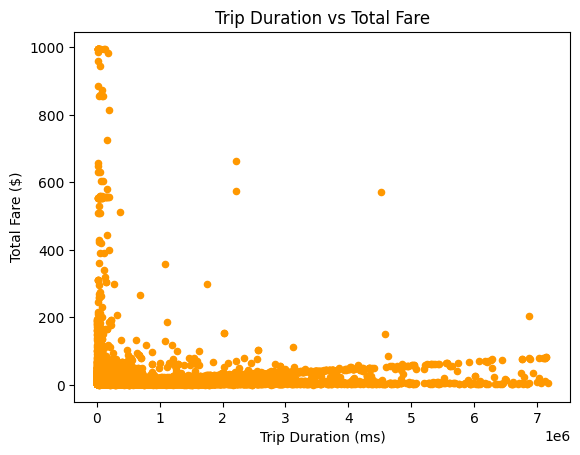

Correlation Coefficient: 0.10505661218057376


In [5]:
taxi_data.plot.scatter(x='trip_duration_ms',y='total_fare_amount', color = '#FF9800')
plt.title('Trip Duration vs Total Fare')
plt.xlabel('Trip Duration (ms)')
plt.ylabel('Total Fare ($)')
plt.show()

fare_duration_corr_coefficient, p_value_2 = pearsonr(taxi_data['total_fare_amount'], taxi_data['trip_duration_ms'])
print(f"Correlation Coefficient: {fare_duration_corr_coefficient}")


###**Interpretation of Duration and Fare**

With a correlation coefficient of 0.1, fare and distance exhibit a slight positive relationship within this dataset. As trip time increases, fares tend to increase as well. Yet since the value of the coefficient is relatively low, other variables are likely more consequential to total fare price.

**Complete Dataset Correlation -- Duration & Fare**

Without removing any unrealistic trips, Correlation Coefficient: 0.4364420146432415
------------------------------------------------------------------------


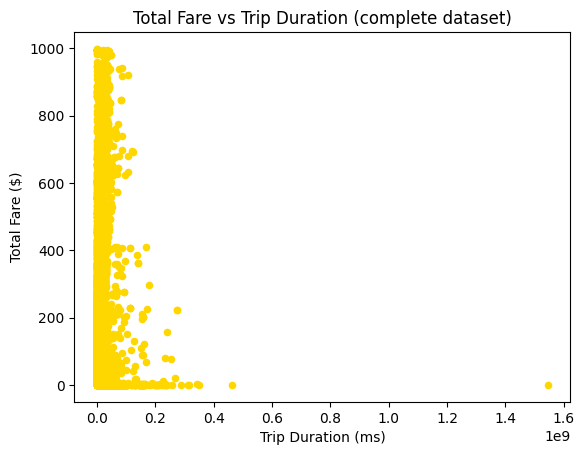

In [6]:
complete_corr = taxi_data_complete[['total_fare_amount', 'trip_duration_ms']].dropna()
fare_duration_corr_complete, p_value_3 = pearsonr(complete_corr['total_fare_amount'], complete_corr['trip_duration_ms'])
print(f"Without removing any unrealistic trips, Correlation Coefficient: {fare_duration_corr_complete}")
print("------------------------------------------------------------------------")
complete_corr.plot.scatter(x='trip_duration_ms',y='total_fare_amount', color='#ffd700')
plt.title('Total Fare vs Trip Duration (complete dataset)')
plt.xlabel('Trip Duration (ms)')
plt.ylabel('Total Fare ($)')
plt.show()

###**Interpretation of Complete Dataset's Correlation**
Using the complete dataset, the relationship between fare and trip duration appears stronger (correlation ≈ 0.4).

However, this result is driven in part by atypical trips and data quality issues, including extreme durations. When analysis is restricted to valid, representative trips, evidence of this relationship decreases notably, suggesting that duration plays a more limited role in fare prcing.


**Time of Day and Fare**

Average fare by hour of the day:


,hour_of_day,total_fare_amount
0,0,8.17
1,1,7.64
2,2,7.56
3,3,7.94
4,4,7.59
5,5,7.88
6,6,8.41
7,7,7.07
8,8,7.19
9,9,7.32


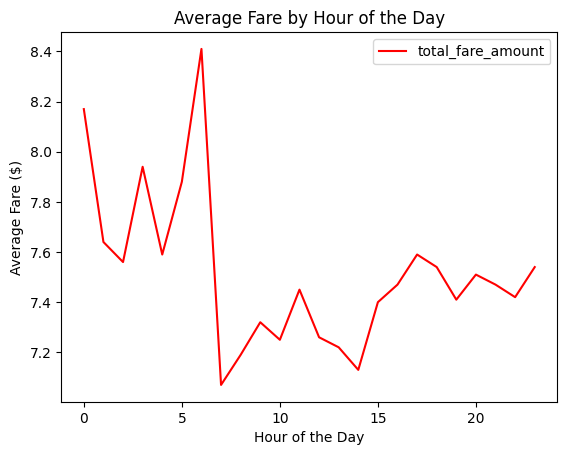

In [8]:
taxi_data = taxi_data[taxi_data['total_fare_amount'] > 0].copy()

taxi_data.loc[:, 'hour_of_day'] = taxi_data['start_time_local'].dt.hour
hourly_fare_data = taxi_data.groupby('hour_of_day')['total_fare_amount'].mean().reset_index()
hourly_fare_data = round(hourly_fare_data, 2)
print("Average fare by hour of the day:")
display(hourly_fare_data)

hourly_fare_data.plot.line(x='hour_of_day', y='total_fare_amount', color='red')
plt.title('Average Fare by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare ($)')
plt.show()

###**Interpretation of Fare by Hour of Day**

Though varying little in absolute range, a noticable drop in fare price is seen from 6 AM to 7 AM.

Without aditioinal contextual data, an exact cause cannot be determined. The change may reflect different trip composition, rider behavior, or operational environments.

**Equivalent SQL logic for this query**
```
SELECT
  EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_fare,
  AVG(total_fare_amount) AS avg_fare,
  COUNT(*) AS trip_count
FROM taxi_data
GROUP BY hour_of_fare;
```

###**Day of Week Trip Distribution**

**SQL logic for this query**
```
SELECT
  EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS day_of_week,
  AVG(total_fare_amount) AS avg_fare,
  COUNT(*) AS trip_count
FROM taxi_trips
WHERE total_fare_amount IS NOT NULL
  AND total_fare_amount > 0
GROUP BY day_of_week
ORDER BY day_of_week;
```
Volume of trips varries by day of week, with weekdays being the most popular, though differences in volume are relatively modest.

Preliminary SQL aggregation showed patterns consistent with the larger Python analysis, indicating that timing based factors play a relatively small role in in pricing variations.

**Conversion of cleaned and aggregated tables into CSV file for use in Tableau.**

Tableau dashboard includes a spatial analysis of pickup locations.

In [9]:
hourly_fare_data.to_csv('hourly_fare_data.csv', index=False)
taxi_data.to_csv('taxi_data_aggregated.csv', index=False)

#**Key Findings**
*   In comparing the effects of distance versus duration, there is no evidence that one variable was more consequential for fare pricing, as both showed weak relationships within the typical trips dataset.
*   Both day of week and time of day components show some variation in pricing, but the differnces are marginal.



**Limitations of Study**
*   Data is limited to the scope of San Francisco from 2023 to 2025. The findings of this study are dependent on the unique operating conditions within San Francisco during this period.
*   Although the data includes certain app based methods of hailing taxis, broader data is needed to understand how taxi usage is affected by autonomous vehicle and rideshare apps.



**Next Steps**
*   Explore more comprehensive datasets that might shed light on impact in taxi trip volume with the introduction of rideshare apps and autonomous vehicles in the city.
*   Only a few variables were studied (duration, distance, and time of day), but examining the impact of other variables like base pricing.


